# Autoencoders

**Objetivo**: construir um visualizador de imagens (dígitos escritos à mão) a partir de um sub-espaço latente. Ou seja, primeiro vamos reduzir a dimensionalidade das imagens (MNIST) e depois reconstruí-las a partir desse novo subespaço.

Notebook de referência: https://www.kaggle.com/code/rvislaywade/visualizing-mnist-using-a-variational-autoencoder/notebook

In [20]:
# Precisamos instalar dois pacotes com versões diferentes, mas o Google Colab não suporta. 
# Então fiz no Jupyter Notebook padrão.
# !pip install tensorflow==1.13
# !pip install q keras==2.0.8

In [45]:
import os
import warnings
import numpy as np
import pandas as pd
from keras import Input
import scipy.stats as sts
# from google.colab import drive
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.metrics import binary_crossentropy
from keras.layers import Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, Layer

# ignorar os warnings
warnings.filterwarnings('ignore')

In [22]:
# conectar colab no google drive
# drive.mount('/content/drive')

In [23]:
# definindo algumas constantes
# DATA_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/DeepLearningTensorflow/data'
DATA_PATH = './data'
TRAIN_FILE = os.path.join(DATA_PATH, 'mnist_train.csv')
TEST_FILE = os.path.join(DATA_PATH, 'mnist_test.csv')

In [24]:
# carregar ambas as bases
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# verificando tamanhos
print('Treino:', train.shape)
print('Teste:', test.shape)

Treino: (42000, 785)
Teste: (28000, 784)


In [26]:
# criando uma coluna falsa de label para o teste
test['label'] = 11

# reorganizando as colunas
testCols = test.columns.to_list()
testCols = testCols[-1:] + testCols[:-1]
test = test[testCols]
test.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# combinando colunas treino e teste
combined = pd.concat([train, test], ignore_index=True)
combined.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
combined.shape

(70000, 785)

In [29]:
# refazer nossa amostra de treino e teste
test = combined.sample(n=10000, random_state=2)
train = combined.loc[~combined.index.isin(test.index)]

# liberar um pouco de memória
del combined

## Pre-Processamento dos Dados

- eliminar o  label
- realizar a normalização dos dados

In [30]:
# criar a matriz dos x's
x_train = train.drop(columns=['label'])
x_test = test.drop(columns=['label'])

# salvando os labels para depois
y_train = train[['label']]
y_test = test[['label']]

# normalizar os dados
x_train = x_train.astype('float32') / 255.
x_train = x_train.values.reshape(-1, 28, 28, 1)

x_test = x_test.astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1)

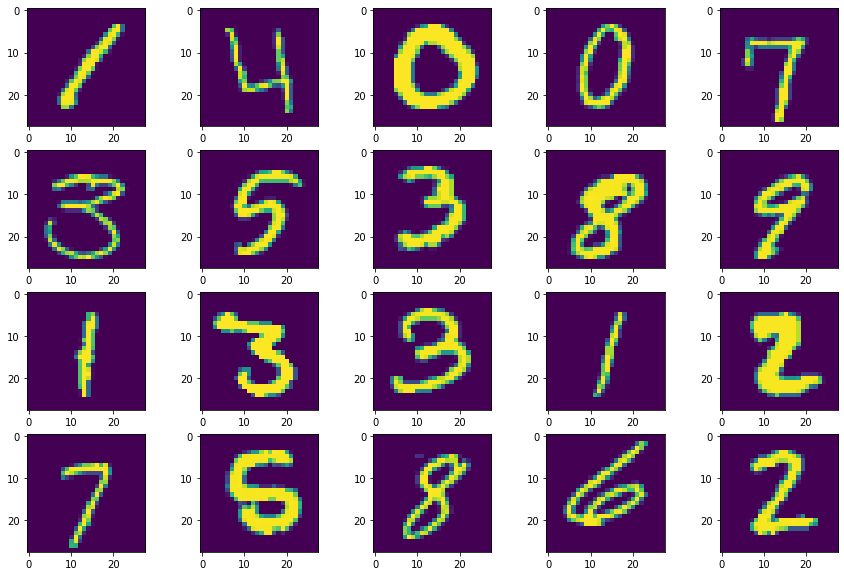

In [31]:
# amostrar 20 imgens aleatórias
sample_imgs = np.random.randint(0, x_train.shape[0], 20)

# plotar as imagens
fig = plt.figure(figsize=(15, 10))
for i in range(20):
  ax = fig.add_subplot(4, 5, i+1)
  ax.imshow(x_train[i][:, :, 0])

plt.show()

## Construir o Modelo

1. Encoder - aprender os parâmetros (média e variância) da distribuição latente
2. Amostrador - amostragem daquela distribuição aprendida
3. Decoder - trazer a amostra do item 2 de volta para o espaço original

In [32]:
# definições
img_shape = (28, 28, 1)     # tamanho da imagem
batch_size = 8              # tamanho da batelada
latent_dim = 2              # dimensões do espaço latente

In [33]:
"""
Arquitetura - Encoder
Input -> 4 Conv2D -> Flatten -> Dense
"""
input_img = Input(shape=img_shape)

# Conv2D - 1
x = Conv2D(32, 3,
            padding='same',
            activation='relu')(input_img)

# Conv2D - 2
x = Conv2D(64, 3,
            padding='same',
            activation='relu',
            strides=(2, 2))(x)

# Conv2D - 3
x = Conv2D(64, 3,
            padding='same',
            activation='relu')(x)

# Conv2D - 4
x = Conv2D(64, 3,
            padding='same',
            activation='relu')(x)

# vamos precisar armazenar o tamanho da rede
shape_before_flattening = K.int_shape(x)

# camada Flatten
x = Flatten()(x)

# camada Densa
x = Dense(32, activation='relu')(x)

# duas saídas - média e log(variância) - devido a estarmos
# treinando um Variational AutoEncoder
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [34]:
def sampling(args) -> object:

    z_mu, z_log_sigma = args[0], args[1]

    epsilon = K.random_normal(
        shape=(K.shape(z_mu)[0], latent_dim),
        mean=0., stddev=1.
    )

    return z_mu + K.exp(z_log_sigma) * epsilon

# realizando a amostragem
z = Lambda(sampling)([z_mu, z_log_sigma])

In [35]:
"""
Arquitetura - Decoder
inverso do encoder
"""
# decoder recebe a amostra feita da distribuição do encoder
# como entrada
decoder_input = Input(K.int_shape(z)[1:])

# expandir a amostra para a mesma dimensão antes do flattening
x = Dense(np.prod(shape_before_flattening[1:]),
          activation='relu')(decoder_input)

# reformatando para garantir a entrada das camadas convolucionais
x = Reshape(shape_before_flattening[1:])(x)

# usar Conv2DTranspose para reverter as camadas convolucionais
# do encoder
x = Conv2DTranspose(32, 3,
                    padding='same',
                    activation='relu',
                    strides=(2,2))(x)

x = Conv2D(1, 3,
            padding='same',
            activation='sigmoid')(x)

# declarar o modelo Decoder
decoder = Model(decoder_input, x)

# decodificando a amostra
z_decoded = decoder(z)

In [36]:
# implementar as funções de custo
class CustomVariationalLayer(Layer):

  def vae_loss(self, x, z_decoded):

    # vetorizando as entradas
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    # erro de reconstrução
    loss = binary_crossentropy(x, z_decoded)

    # divergência KL (Kullback-Leibler)
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=1)

    return K.mean(loss + kl_loss)

  def call(self, inputs):

    x = inputs[0]
    z_decoded = inputs[1]

    loss = self.vae_loss(x, z_decoded)

    self.add_loss(loss, inputs=inputs)

    return x

In [37]:
# aplicar a função de perda para as input images e as imagens decodificadas
y = CustomVariationalLayer()([input_img, z_decoded])

In [38]:
# instanciar o modelo
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 28, 28, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 14, 14, 64)    18496       conv2d_6[0][0]                   
____________________________________________________________________________________________________
conv2d_8 (Conv2D)                (None, 14, 14, 64)    36928       conv2d_7[0][0]                   
___________________________________________________________________________________________

In [39]:
# ajustar o modelo
vae.fit(
    x=x_train,
    y=None,
    epochs=10,
    batch_size=batch_size,
    validation_data=(x_test, None)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 244s - loss: 0.2356 - val_loss: 0.1961
Epoch 2/10
60000/60000 [==============================] - 276s - loss: 0.1912 - val_loss: 0.1917
Epoch 3/10
60000/60000 [==============================] - 269s - loss: 0.1876 - val_loss: 0.1894
Epoch 4/10
60000/60000 [==============================] - 278s - loss: 0.1857 - val_loss: 0.1874
Epoch 5/10
60000/60000 [==============================] - 278s - loss: 0.1845 - val_loss: 0.1873
Epoch 6/10
60000/60000 [==============================] - 274s - loss: 0.1836 - val_loss: 0.1846
Epoch 7/10
60000/60000 [==============================] - 281s - loss: 0.1829 - val_loss: 0.1851
Epoch 8/10
60000/60000 [==============================] - 274s - loss: 0.1823 - val_loss: 0.1844
Epoch 9/10
60000/60000 [==============================] - 281s - loss: 0.1819 - val_loss: 0.1833
Epoch 10/10
60000/60000 [==============================] - 275s - loss: 0.181

## Isolamento de dígitos no espaço latente

In [41]:
# isolamento do conjunto de treinamento original no conjunto de teste
valid_noTest = test[test['label'] != 11]

# separando em x e y
x_valid_noTest = valid_noTest.drop(columns=['label'])
y_valid_noTest = valid_noTest['label']

# reformatação e normalização
x_valid_noTest = x_valid_noTest.astype('float32') / 255.
x_valid_noTest = x_valid_noTest.values.reshape(-1, 28, 28, 1)

In [42]:
# codificar imagens para o espaço latente
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(x_valid_noTest, batch_size=batch_size)

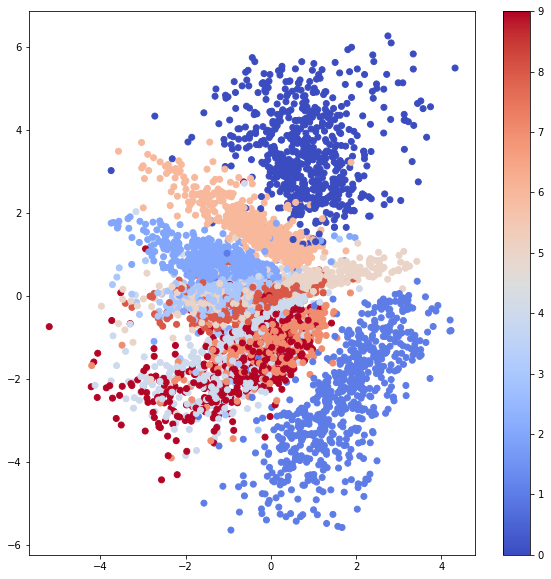

In [44]:
# visualizando o espaço latente
plt.figure(figsize=(10, 10))
plt.scatter(
    x=x_valid_noTest_encoded[:, 0],
    y=x_valid_noTest_encoded[:, 1],
    c=y_valid_noTest,
    cmap='coolwarm'
)
plt.colorbar()
plt.show()

- verifique que a barra de cores representa o valor dos labels que cada imagem possui.
    - 7, 8 e 9 são clusters bem parecidos (praticamente sobrepostos)
    - 0 são mais próximos de 6, apesar de haver uma fronteira bem definida
    - 4 também está sobreposto com 9s

### Geração de Dígitos

Podemos finalmente usar a rede decodificadora para gerar os dígitos baseados em gradientes bem definidos. O resultado é uma matriz que apresenta uma transição suave de dígitos, com base na precisão dos vetores usados para gerá-los.

In [51]:
# visualização de uma matriz suavemente gerada
n = 15      # figura com 30 x 30 digitos
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# construindo uma grade de valores das variáveis latentes
grid_x = sts.norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = sts.norm.ppf(np.linspace(0.05, 0.95, n))

In [52]:
# aplicar o decoder para cada quadrado no grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # construir array com os valores amostrados
        z_sample = np.array([[xi, yi]])

        # criar um tensor com o formato esperado pelo decoder
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        # realizar a decodificação do tensor
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        # reformatar para imagem com o tamanho adequado
        digit = x_decoded[0].reshape(digit_size, digit_size)

        # incluir na figura
        figure[
            i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

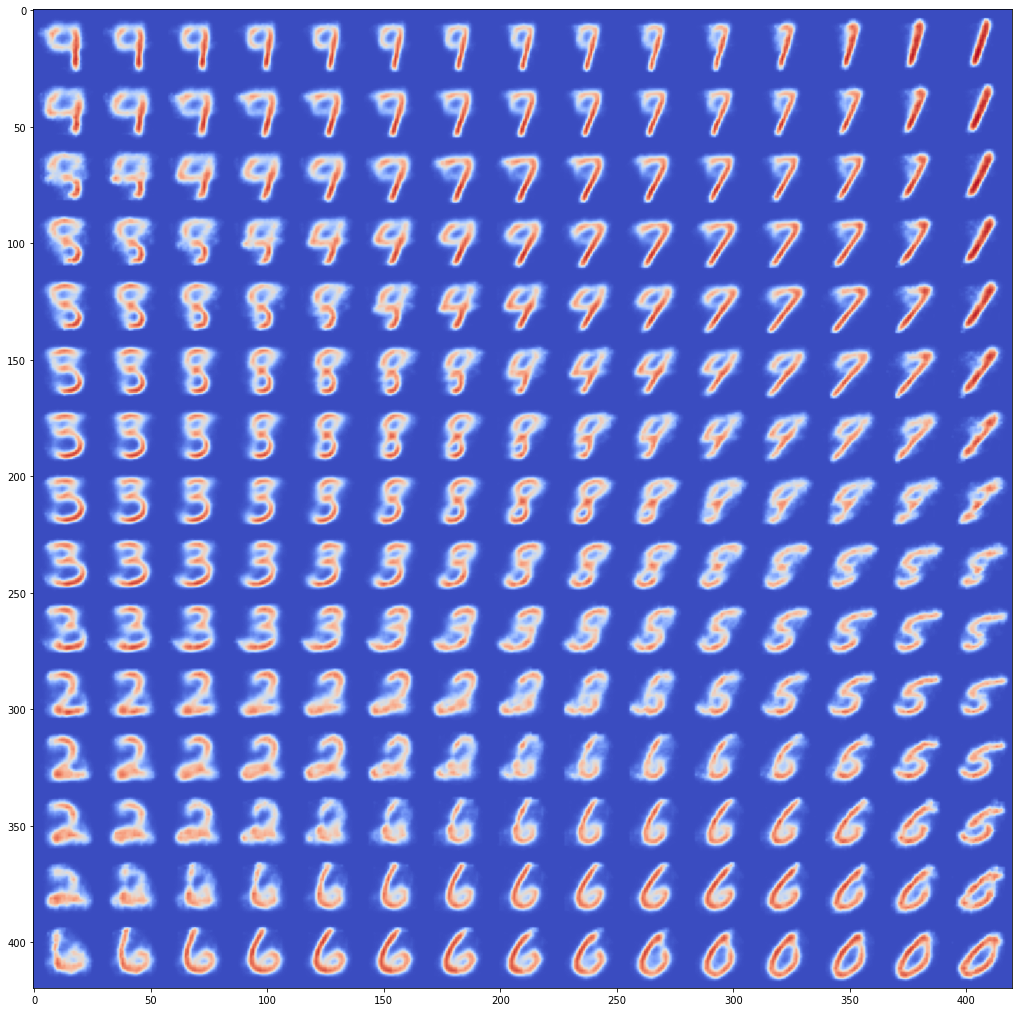

In [53]:
# exibir a figura
plt.figure(figsize=(18, 18))
plt.imshow(figure, cmap='coolwarm')
plt.show()